In [1]:
# Required Libraries installation
!pip install pyspark
!pip install pandas scikit-learn nltk pygal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=b383385ea91efc0fd9be1196a9d9cba357d067dcaab2559358c94ae27929de46
  Stored in directory: /root/.cache/pip/wheels/9f/34/a4/159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 3.7 MB/s eta 0:00:00


In [118]:
# Importing Libraries
from google.colab import drive
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, isnan, when,round,month,datediff, to_date
import math
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.window import Window
from functools import reduce
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import pygal
import nltk
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType, StructType, StructField
from pyspark.sql.types import IntegerType

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
# Create a SparkSession
spark = SparkSession.builder.master("local[4]").appName("ClusterShop").getOrCreate()

# set log level to Error
spark.sparkContext.setLogLevel("ERROR")


In [30]:
# Read the Excel file using Pandas
df_pandas = pd.read_excel("drive/MyDrive/Online Retail.xlsx",na_values='')

# Convert the Pandas DataFrame to PySpark DataFrame 
df_spark = spark.createDataFrame(df_pandas)

In [64]:
# helper functions
def show_df(df, n=5):
  return df.show(n)

def df_stats(df):
  return df.describe().show()



def percent_missing(df):
  # get columns excluding 'InvoiceDate'
  cols = [col for col in df.columns if col != 'InvoiceDate']


  # count missing values in each column as a percentage of the total number of values and total number of values in each column
  df.select([count(when(~isnan(c), c)).alias(c) for c in cols]).show()
  df.select([count(when(isnan(c), c)).alias(c) for c in cols]).show()

def values_distribution(df,col,bins=100,xlim=10000,xlabel='TotalCost',ylabel='Frequency',title='Distribution of basket prices'):

  # convert the PySpark DataFrame to Pandas DataFrame
  df_pd = df.toPandas()

  # plot the histogram
  fig, ax = plt.subplots()
  ax.hist(df_pd[col], bins=bins)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title(title)
  plt.rc('xtick', labelsize=10)
  plt.rc('ytick', labelsize=10)
  ax = plt.gca()
  ax.set_xlim([0,xlim])
  plt.show()

In [34]:
percent_missing(df_spark)

+---------+---------+-----------+--------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+---------+----------+-------+
|   541909|   541909|     540455|  541909|   541909|    406829| 541909|
+---------+---------+-----------+--------+---------+----------+-------+

+---------+---------+-----------+--------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+---------+----------+-------+
|        0|        0|       1454|       0|        0|    135080|      0|
+---------+---------+-----------+--------+---------+----------+-------+



In [75]:
# filter out the missing values using map 
df_spark_filtered = df_spark.rdd.map(lambda x: x if not math.isnan(x['CustomerID'])  else None).filter(lambda x: x is not None).toDF()

In [76]:
# get percentage of cancelled invoices using map reduce in spark rdd
unique_invoice = df_spark_filtered.select('InvoiceNo').distinct().count()
cancelled_invoice_count = df_spark_filtered.select('InvoiceNo').rdd.map(lambda x: x if x.InvoiceNo.startswith('C') else None).filter(lambda x: x is not None).toDF()

cancelled_invoice_count = cancelled_invoice_count.select('InvoiceNo').distinct().count()


# percentage of cancelled invoices
print("Percentage of cancelled invoices: ", (cancelled_invoice_count/unique_invoice)*100)

Percentage of cancelled invoices:  16.466876971608833


In [77]:
original_cols = df_spark.columns

In [78]:
# Define a function to compute the total cost for each basket
def calculate_basket_total(row):
    customer_id, invoice_no, quantity, unit_price = row
    total_cost = quantity * unit_price
    return ((customer_id, invoice_no), total_cost)

# Map the input DataFrame to (key, value) pairs, where the key is a tuple of (CustomerID, InvoiceNo) and the value is the TotalCost
rdd = df_spark_filtered.rdd.map(lambda row: calculate_basket_total((row['CustomerID'], row['InvoiceNo'], row['Quantity'], row['UnitPrice'])))

# Reduce the RDD by key (i.e., CustomerID and InvoiceNo), summing the TotalCost for each basket
basket_rdd = rdd.reduceByKey(lambda a, b: a + b)

# Convert the resulting RDD of (key, value) pairs to a DataFrame, and rename the TotalCost column
basket_price = basket_rdd.map(lambda row: (row[0][0], row[0][1], row[1])).toDF(['CustomerID', 'InvoiceNo', 'TotalCost'])

# Sort the DataFrame by CustomerID
basket_price = basket_price.sort('CustomerID')

# Show the contents of the new DataFrame
show_df( basket_price)

+----------+---------+---------+
|CustomerID|InvoiceNo|TotalCost|
+----------+---------+---------+
|   12346.0|   541431|  77183.6|
|   12346.0|  C541433| -77183.6|
|   12347.0|   549222|   636.25|
|   12347.0|   562032|   584.91|
|   12347.0|   537626|   711.79|
+----------+---------+---------+
only showing top 5 rows



In [79]:
# stats of total cost in basket price
df_stats(basket_price.select('TotalCost'))

+-------+------------------+
|summary|         TotalCost|
+-------+------------------+
|  count|             22190|
|   mean| 374.0453273546637|
| stddev|2018.4828692316019|
|    min|         -168469.6|
|    max|          168469.6|
+-------+------------------+



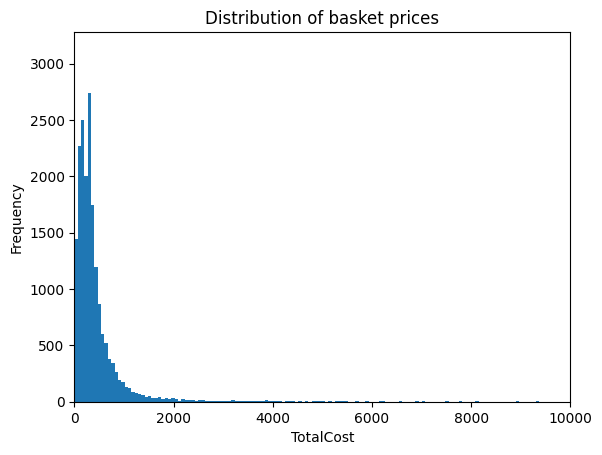

In [80]:
values_distribution(basket_price,'TotalCost',bins=5000,xlim=10000,xlabel='TotalCost',ylabel='Frequency',title='Distribution of basket prices')

In [81]:
# Define a function to compute the sum and count for each customer
def calculate_customer_stats(row):
    customer_id, total_cost = row
    return (customer_id, (total_cost, 1))

# Map the basket_price DataFrame to (key, value) pairs, where the key is the CustomerID and the value is a tuple containing the TotalCost and a count of 1
rdd = basket_price.rdd.map(lambda row: (row['CustomerID'], row['TotalCost'])).map(calculate_customer_stats)

# Reduce the RDD by key (i.e., CustomerID), summing the TotalCost and count for each customer
customer_rdd = rdd.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))

# Map the resulting RDD of (key, value) pairs to (key, value) pairs where the key is the CustomerID and the value is the average purchase value
avg_purchase_value_rdd = customer_rdd.map(lambda row: (row[0], row[1][0] / row[1][1]))

# Convert the resulting RDD of (key, value) pairs to a DataFrame, and rename the column
avg_purchase_value = avg_purchase_value_rdd.toDF(['CustomerID', 'AvgPurchaseValue'])

# Show the contents of the new DataFrame
show_df(avg_purchase_value)

+----------+------------------+
|CustomerID|  AvgPurchaseValue|
+----------+------------------+
|   12346.0|               0.0|
|   12347.0| 615.7142857142857|
|   12348.0|449.31000000000006|
|   12349.0|           1757.55|
|   12350.0|334.40000000000003|
+----------+------------------+
only showing top 5 rows



In [83]:
df_stats(avg_purchase_value.select('AvgPurchaseValue'))

+-------+------------------+
|summary|  AvgPurchaseValue|
+-------+------------------+
|  count|              4372|
|   mean|315.88340742424185|
| stddev| 361.2373033626041|
|    min|          -4287.63|
|    max| 6207.669999999996|
+-------+------------------+



In [85]:
avg_purchase_value.filter(avg_purchase_value['AvgPurchaseValue'] < 0).count()
customers_with_neg_avg_purchase_value = avg_purchase_value.filter(avg_purchase_value['AvgPurchaseValue'] < 0).select('CustomerID','AvgPurchaseValue').collect()

# remove the customers with negative avg purchase value from df_spark_filtered
print("transactions before removing customers with negative avg purchase value: ", df_spark_filtered.count())
df_spark_filtered = df_spark_filtered.filter(~df_spark_filtered['CustomerID'].isin([x['CustomerID'] for x in customers_with_neg_avg_purchase_value]))
print("transactions after removing customers with negative avg purchase value: ", df_spark_filtered.count())


transactions before removing customers with negative avg purchase value:  406829
transactions after removing customers with negative avg purchase value:  406431


In [86]:
avg_purchase_value = avg_purchase_value.filter(~avg_purchase_value['CustomerID'].isin([x['CustomerID'] for x in customers_with_neg_avg_purchase_value]))
basket_price = basket_price.filter(~basket_price['CustomerID'].isin([x['CustomerID'] for x in customers_with_neg_avg_purchase_value]))

In [87]:
df_stats(avg_purchase_value.select('AvgPurchaseValue'))

+-------+------------------+
|summary|  AvgPurchaseValue|
+-------+------------------+
|  count|              4330|
|   mean|321.55568681881095|
| stddev|351.36404226039366|
|    min|               0.0|
|    max| 6207.669999999996|
+-------+------------------+



In [88]:
# stats of total cost in basket price
df_stats(basket_price.select('TotalCost'))

+-------+------------------+
|summary|         TotalCost|
+-------+------------------+
|  count|             22125|
|   mean|375.74214481355875|
| stddev|  2020.86601904734|
|    min|         -168469.6|
|    max|          168469.6|
+-------+------------------+



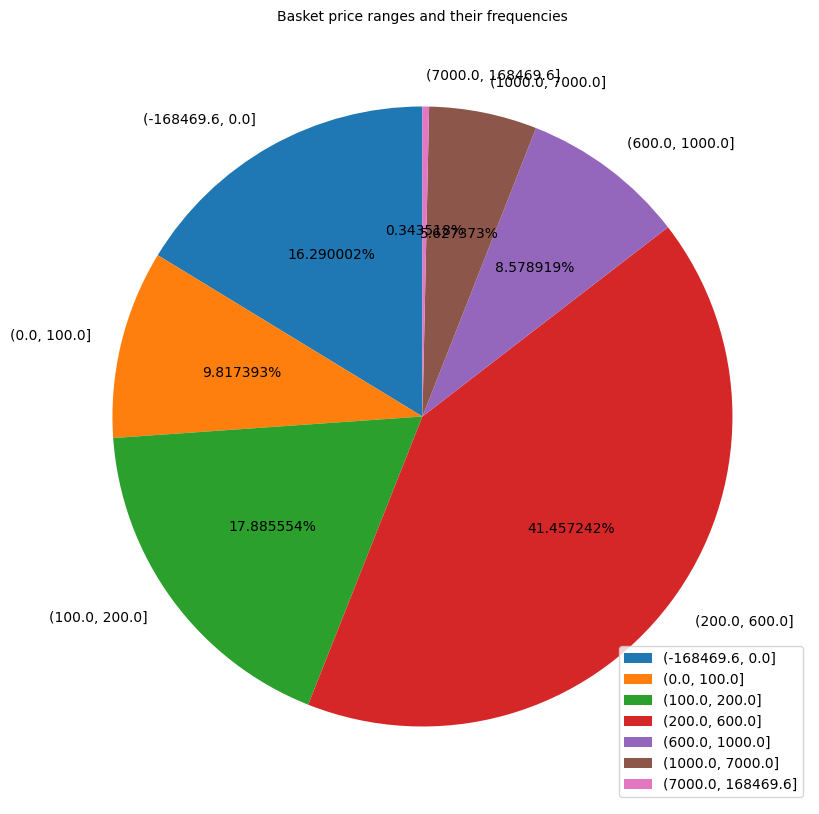

In [98]:
# construct ranges for the basket prices and count the number of baskets in each range
ranges = [-168469.6,0, 100, 200, 600, 1000, 7000,168469.6]
basket_price_pd = basket_price.toPandas()
basket_price_range = basket_price_pd.groupby(pd.cut(basket_price_pd['TotalCost'], ranges)).count()
basket_price_range

# plot pie chart of the basket ranges and their frequencies
ax, fig = plt.subplots(figsize=(10,15))
# plot pie chart
plt.pie(basket_price_range['TotalCost'], labels=basket_price_range.index, autopct='%1f%%', startangle=90)
# title
plt.title('Basket price ranges and their frequencies', fontsize=10)
# legend
plt.legend(basket_price_range.index, loc='lower right', fontsize=10)
plt.show()


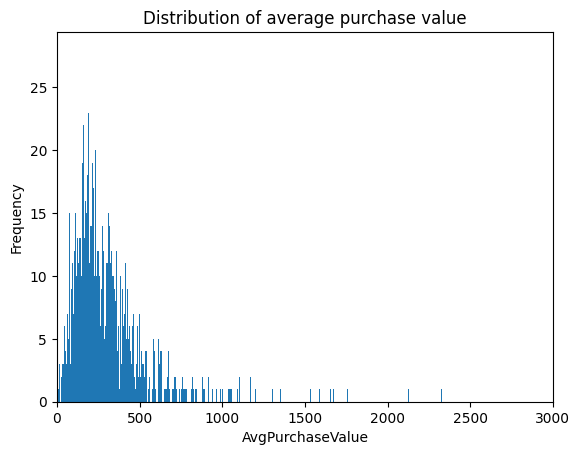

In [99]:
values_distribution(avg_purchase_value,col='AvgPurchaseValue',bins=5000,xlim=3000,xlabel='AvgPurchaseValue',title='Distribution of average purchase value')

In [100]:
# Map the basket_price DataFrame to (key, value) pairs, where the key is the CustomerID and the value is 1
rdd = basket_price.rdd.map(lambda row: (row['CustomerID'], 1))

# Reduce the RDD by key (i.e., CustomerID), summing the counts for each customer
customer_rdd = rdd.reduceByKey(lambda a, b: a + b)

# Convert the resulting RDD of (key, value) pairs to a DataFrame, and rename the column
frequency_of_purchases = customer_rdd.toDF(['CustomerID', 'FrequencyOfPurchases'])

# Show the contents of the new DataFrame
show_df(frequency_of_purchases)

+----------+--------------------+
|CustomerID|FrequencyOfPurchases|
+----------+--------------------+
|   12346.0|                   2|
|   12347.0|                   7|
|   12348.0|                   4|
|   12349.0|                   1|
|   12350.0|                   1|
+----------+--------------------+
only showing top 5 rows



In [101]:
df_stats(frequency_of_purchases.select('FrequencyOfPurchases'))

+-------+--------------------+
|summary|FrequencyOfPurchases|
+-------+--------------------+
|  count|                4330|
|   mean|   5.109699769053118|
| stddev|   9.376827828095204|
|    min|                   1|
|    max|                 248|
+-------+--------------------+



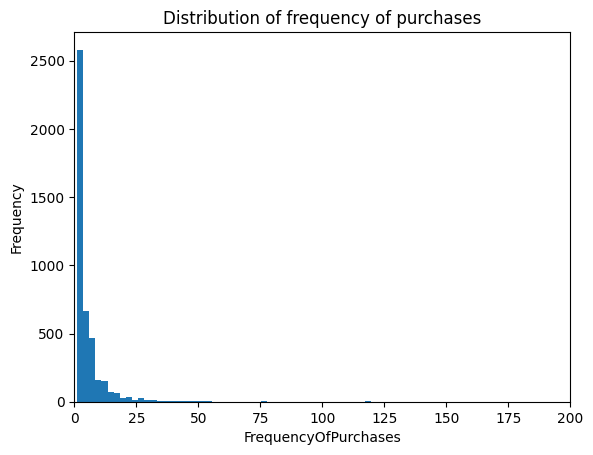

In [106]:
values_distribution(frequency_of_purchases,col='FrequencyOfPurchases',bins=100,xlim=200,xlabel='FrequencyOfPurchases',title='Distribution of frequency of purchases')

In [124]:
from pyspark.sql.functions import min as min_builtin
from pyspark.sql.functions import max as max_builtin
from builtins import min,max
# convert InvoiceDate column to date
df_spark_filtered = df_spark_filtered.withColumn('InvoiceDate', to_date(df_spark_filtered['InvoiceDate']))

# calculate the difference between the last and the first purchase
window = Window.partitionBy('CustomerID').orderBy('InvoiceDate')
df_spark_filtered = df_spark_filtered.withColumn('FirstPurchase', min_builtin('InvoiceDate').over(window))
df_spark_filtered = df_spark_filtered.withColumn('LastPurchase', max_builtin('InvoiceDate').over(window))

# Map the df_spark_filtered DataFrame to (key, value) pairs, where the key is the CustomerID and the value is a tuple containing the InvoiceDate, FirstPurchase, and LastPurchase
rdd = df_spark_filtered.rdd.map(lambda row: (row['CustomerID'], (row['InvoiceDate'], row['FirstPurchase'], row['LastPurchase'])))

# Reduce the RDD by key (i.e., CustomerID), finding the minimum and maximum InvoiceDate for each customer
customer_rdd = rdd.reduceByKey(lambda a, b: (min(a[0], b[0]), min(a[1], b[1]), max(a[2], b[2])))


# Map the resulting RDD of (key, value) pairs to (key, value) pairs where the key is the CustomerID and the value is the difference in days between the LastPurchase and FirstPurchase
customer_lifetime_value_rdd = customer_rdd.map(lambda row: (row[0], (row[1][2] - row[1][1]).days))

# Convert the resulting RDD of (key, value) pairs to a DataFrame, and rename the column
customer_lifetime_value = customer_lifetime_value_rdd.toDF(['CustomerID', 'CustomerLifetimeValue'])

# Show the contents of the new DataFrame
customer_lifetime_value.show()

+----------+---------------------+
|CustomerID|CustomerLifetimeValue|
+----------+---------------------+
|   12356.0|                  303|
|   12364.0|                  105|
|   12380.0|                  164|
|   12408.0|                  228|
|   12424.0|                    0|
|   12484.0|                  304|
|   12488.0|                   66|
|   12500.0|                  310|
|   12536.0|                   52|
|   12600.0|                  343|
|   12616.0|                  212|
|   12624.0|                   71|
|   12640.0|                   58|
|   12648.0|                    0|
|   12668.0|                  348|
|   12700.0|                  208|
|   12836.0|                  252|
|   12856.0|                   56|
|   12912.0|                   38|
|   12920.0|                    0|
+----------+---------------------+
only showing top 20 rows



In [125]:
df_stats(customer_lifetime_value.select('CustomerLifetimeValue'))

+-------+---------------------+
|summary|CustomerLifetimeValue|
+-------+---------------------+
|  count|                 4330|
|   mean|   134.68198614318706|
| stddev|   133.05067847782422|
|    min|                    0|
|    max|                  373|
+-------+---------------------+



In [127]:
# Convert the DataFrame to an RDD
rdd = df_spark_filtered.rdd

# Map the RDD to (key, value) pairs, where the key is a tuple of (CustomerID, InvoiceNo) and the value is the Quantity
rdd_keyed = rdd.map(lambda row: ((row['CustomerID'], row['InvoiceNo']), row['Quantity']))

# Reduce the RDD by key, summing the Quantities for each unique (CustomerID, InvoiceNo) pair
rdd_reduced = rdd_keyed.reduceByKey(lambda a, b: a + b)

# Map the resulting RDD of (key, value) pairs to a new RDD of (CustomerID, InvoiceNo, BasketSize) tuples
rdd_output = rdd_reduced.map(lambda row: (row[0][0], row[0][1], row[1]))

# Convert the resulting RDD to a DataFrame
basket_size = rdd_output.toDF(['CustomerID', 'InvoiceNo', 'BasketSize'])

# Show the contents of the new DataFrame
basket_size.show()

+----------+---------+----------+
|CustomerID|InvoiceNo|BasketSize|
+----------+---------+----------+
|   12356.0|   549435|       370|
|   12359.0|  C549955|        -4|
|   12359.0|   571034|       657|
|   12365.0|  C544577|        -1|
|   12379.0|  C559193|        -1|
|   12379.0|   567196|       196|
|   12381.0|   563100|       568|
|   12381.0|   574694|       146|
|   12383.0|   540971|       590|
|   12383.0|  C541586|        -3|
|   12390.0|   567530|       353|
|   12394.0|   552188|       182|
|   12401.0|   543537|        11|
|   12408.0|   547685|        26|
|   12408.0|   574862|       365|
|   12408.0|  C574865|        -1|
|   12414.0|   543027|       145|
|   12421.0|   557297|       145|
|   12421.0|   578339|        77|
|   12424.0|   558537|       208|
+----------+---------+----------+
only showing top 20 rows



In [128]:
df_stats(basket_size.select('BasketSize'))

+-------+------------------+
|summary|        BasketSize|
+-------+------------------+
|  count|             22125|
|   mean| 221.8508474576271|
| stddev|1171.7778905485325|
|    min|            -80995|
|    max|             80995|
+-------+------------------+



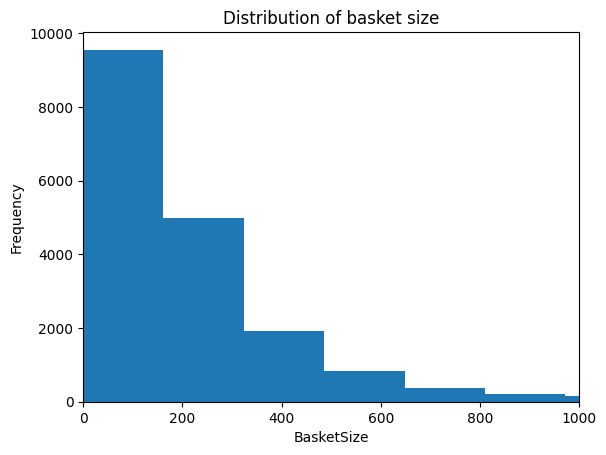

In [129]:
values_distribution(basket_size,'BasketSize',bins=1000,xlim=1000,title='Distribution of basket size',xlabel='BasketSize')

In [131]:
def averaging(df,group_col,summary_col,new_col):
  rdd = df.rdd

  # Map the RDD to (key, value) pairs, where the key is the group_col and the value is the summary_col
  rdd_keyed = rdd.map(lambda row: (row[group_col], row[summary_col]))

  # Reduce the RDD by key, computing the sum and count of summary_col for each group_col
  rdd_reduced = rdd_keyed.aggregateByKey((0.0, 0), lambda acc, val: (acc[0] + val, acc[1] + 1), lambda acc1, acc2: (acc1[0] + acc2[0], acc1[1] + acc2[1]))

  # Map the resulting RDD of (key, value) pairs to a new RDD of (group_col, new_col) tuples
  rdd_output = rdd_reduced.map(lambda row: (row[0], row[1][0] / row[1][1]))

  # Convert the resulting RDD to a DataFrame
  output = rdd_output.toDF([group_col, new_col])
  return output

In [132]:
avg_basket_price = averaging(basket_price,'CustomerID','TotalCost','AvgBasketPrice')
show_df(avg_basket_price)

+----------+------------------+
|CustomerID|    AvgBasketPrice|
+----------+------------------+
|   12346.0|               0.0|
|   12347.0| 615.7142857142857|
|   12348.0|449.31000000000006|
|   12349.0|           1757.55|
|   12350.0|334.40000000000003|
+----------+------------------+
only showing top 5 rows



In [135]:
avg_basket_size = averaging(basket_size,'CustomerID','BasketSize','AvgBasketSize')
show_df(avg_basket_size)

+----------+------------------+
|CustomerID|     AvgBasketSize|
+----------+------------------+
|   12356.0| 530.3333333333334|
|   12408.0|155.44444444444446|
|   12424.0|             370.0|
|   12484.0|           273.125|
|   12488.0|176.33333333333334|
+----------+------------------+
only showing top 5 rows



In [137]:
# print shapes of the DataFrames
print("avg_basket_price: ", (avg_basket_price.count(), len(avg_basket_price.columns)))
print("frequency_of_purchases: ", (frequency_of_purchases.count(), len(frequency_of_purchases.columns)))
print("basket_size: ", (avg_basket_size.count(), len(avg_basket_size.columns)))
print("customer_lifetime_value: ", (customer_lifetime_value.count(), len(customer_lifetime_value.columns)))

avg_basket_price:  (4330, 2)
frequency_of_purchases:  (4330, 2)
basket_size:  (4330, 2)
customer_lifetime_value:  (4330, 2)


In [138]:
dfs = [avg_basket_price, frequency_of_purchases, avg_basket_size, customer_lifetime_value]

df_final = reduce(lambda left, right: left.join(right, on='CustomerID', how='outer'), dfs)

show_df(df_final)

+----------+------------------+--------------------+------------------+---------------------+
|CustomerID|    AvgBasketPrice|FrequencyOfPurchases|     AvgBasketSize|CustomerLifetimeValue|
+----------+------------------+--------------------+------------------+---------------------+
|   12346.0|               0.0|                   2|               0.0|                    0|
|   12347.0| 615.7142857142857|                   7|351.14285714285717|                  365|
|   12348.0|449.31000000000006|                   4|            585.25|                  283|
|   12349.0|           1757.55|                   1|             631.0|                    0|
|   12350.0|334.40000000000003|                   1|             197.0|                    0|
+----------+------------------+--------------------+------------------+---------------------+
only showing top 5 rows



In [144]:
df_stats(df_final)

+-------+------------------+------------------+--------------------+------------------+---------------------+
|summary|        CustomerID|    AvgBasketPrice|FrequencyOfPurchases|     AvgBasketSize|CustomerLifetimeValue|
+-------+------------------+------------------+--------------------+------------------+---------------------+
|  count|              4330|              4330|                4330|              4330|                 4330|
|   mean|15299.291916859122|321.55568681881095|   5.109699769053118|198.97555181436482|   134.68198614318706|
| stddev|1722.0418499064176|351.36404226039366|   9.376827828095204| 321.8904511396367|   133.05067847782433|
|    min|           12346.0|               0.0|                   1|             -94.5|                    0|
|    max|           18287.0| 6207.669999999996|                 248|           12540.0|                  373|
+-------+------------------+------------------+--------------------+------------------+---------------------+



In [145]:
# create a VectorAssembler object
assembler = VectorAssembler(inputCols=['AvgBasketPrice', 'FrequencyOfPurchases', 'AvgBasketSize', 'CustomerLifetimeValue'], outputCol='features')

# transform the DataFrame
df_final = assembler.transform(df_final)


# create a StandardScaler object
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withStd=True, withMean=False)

# fit the DataFrame to the scaler
scalerModel = scaler.fit(df_final)

# transform the DataFrame
df_assembled = scalerModel.transform(df_final)

# print the first row of the scaled DataFrame
show_df(df_assembled)


+----------+------------------+--------------------+------------------+---------------------+--------------------+--------------------+
|CustomerID|    AvgBasketPrice|FrequencyOfPurchases|     AvgBasketSize|CustomerLifetimeValue|            features|      scaledFeatures|
+----------+------------------+--------------------+------------------+---------------------+--------------------+--------------------+
|   12346.0|               0.0|                   2|               0.0|                    0|       (4,[1],[2.0])|(4,[1],[0.2132917...|
|   12347.0| 615.7142857142857|                   7|351.14285714285717|                  365|[615.714285714285...|[1.75235428689081...|
|   12348.0|449.31000000000006|                   4|            585.25|                  283|[449.310000000000...|[1.27875919547572...|
|   12349.0|           1757.55|                   1|             631.0|                    0|[1757.55,1.0,631....|[5.00207701588739...|
|   12350.0|334.40000000000003|                 

In [ ]:
scaled_features_pd = df_assembled.select('scaledFeatures')

# apply K-means clustering
from pyspark.ml.clustering import KMeans

# create an instance of the K-means algorithm

# kmeans = KMeans(featuresCol='scaledFeatures', k=5, distanceMeasure='cosine')
kmeans = KMeans(featuresCol='features', k=4)
# train the model
model = kmeans.fit(df_assembled)

# make predictions
predictions = model.transform(df_assembled)

# print the cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")

for center in centers:
    print(center)

In [187]:
scaled_features_pd = df_assembled.select('scaledFeatures')

# apply K-means clustering
from pyspark.ml.clustering import KMeans

# create an instance of the K-means algorithm

# kmeans = KMeans(featuresCol='scaledFeatures', k=5, distanceMeasure='cosine')
kmeans = KMeans(featuresCol='features', k=4)
# train the model
model = kmeans.fit(df_assembled)

# make predictions
predictions = model.transform(df_assembled)

# print the cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")

for center in centers:
    print(center)

Cluster Centers: 
[797.38635424   6.         512.49617491 129.18857143]
[3445.60165473   13.34782609 2076.94351292  151.86956522]
[2.15736e+03 1.00000e+00 1.01820e+04 0.00000e+00]
[235.48802378   4.93809524 138.72220813 135.41164021]


In [188]:

# evaluate the model
from pyspark.ml.evaluation import ClusteringEvaluator

# create an instance of the evaluator
evaluator = ClusteringEvaluator()
 
# calculate the silhouette score
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))


Silhouette with squared euclidean distance = 0.7941710822397995


In [189]:
# Distribution of the clusters
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   21|
|         3| 3796|
|         2|    2|
|         0|  511|
+----------+-----+



In [190]:
predictions_pd = predictions.select('scaledFeatures').toPandas()

# number of variables
categories = ['AvgPurchaseValue', 'AvgFrequencyOfPurchases', 'AvgBasketSize', 'AvgCustomerLifetimeValue']

# create a list to store the radar charts
charts = []

# create a radar chart for each cluster and add it to the list
for i in range(len(centers)):
    values = predictions_pd.loc[i, 'scaledFeatures'].toArray().flatten().tolist()
    chart = pygal.Radar(fill=True)
    chart.title = 'Cluster %d' % (i + 1)
    chart.x_labels = categories
    chart.add('Cluster %d' % (i + 1), [x for x in values], fill_color='red')
    chart.show_legend = True
    charts.append(chart)

# create a combined radar chart from the list of charts
combined_chart = pygal.StackedLine(fill=True, interpolate='cubic', style=pygal.style.LightStyle)
combined_chart.title = 'Cluster Analysis'
combined_chart.x_labels = categories
for i in range(len(centers)):
    values = predictions_pd.loc[i, 'scaledFeatures'].toArray().flatten().tolist() 
    combined_chart.add('Cluster %d' % (i + 1), [x for x in values])
combined_chart.render_to_file('cluster_analysis.svg')
    